# Assignment

# Supervised Learning

Work assembled by Alejandro Gonçalves, Pedro Fernandes, Francisca Mihalache.

## Table of Contents <a name="contents"></a>

1. [Introduction](#introduction)

2. [Chosen Algorithm](#chosen-algorithm)

3. [Metrics](#metrics)
            
4. [Distances](#distances)
   - 4.1. [Euclidian Distance](#euclidian-distance)
   - 4.2. [L2 Distance](#l2-distance)
   - 4.3. [Euclidian Distance (features)](#euclidian-distance-features)
   - 4.4. [Cosine Similarity](#cosine-similarity)
   - 4.5. [Manhattan Distance](#manhattan-distance)
   - 4.6. [Jaccard Distance](#jaccard-distance)
   - 4.7. [Mahalanobis Distace](#mahalanobis-distance)
5. [Base](#base)
    - 5.1. [Original KNN](#original-knn)
    - 5.2. [Implementation](#implementation)

6. [Improved Algorithm](#improved-algorithm)
   - 6.1. [Bagging](#Bagging)
   - 6.2. [KNN-Features](#knn-features)
   
7. [Training](#training)
   - 7.1. [Base Training](#base-training)
   - 7.2. [Bagging Training](#bagging-training)
   - 7.3. [Features Training](#features-training)
   
8. [Parameters Test](#parameters) 
    - 8.1. [Best Combination](#best-combination)
    - 8.2. [K Comparison](#k-comparison)
    - 8.3. [Distance Comparison](#distance-comparison)
  
9. [Test Statistics](#statistics)
   - 9.1. [Statistical Performance](#statistical-performance)
   - 9.2. [Comparisons](#comparisons)

10. [Datasets](#datasets)


## Introduction <a name="introduction"></a>

In this assignment we'll dive into a selected Machine Learning (ML) algorithm, understanding its theory and testing its performance. We'll explore benchmarking methodologies and differentiate between ML research and practical application, ensuring a balanced understanding of theory and practice in ML.

 ***Note:*** ***The hyperlinks are functional only when this file is opened in Jupyter. Also, it is recommended to first review the datasets in [[chapter10]](#datasets).***

### Imports
To begin with, we need to import some modules.

In [1]:
import math
import random
import csv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, 
                                     RandomizedSearchCV, cross_validate, LeaveOneOut)
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, r2_score,
                             f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc)
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.utils import resample

from pandas.api.types import is_numeric_dtype

from collections import Counter


## Chosen Algorithm <a name="chosen-algorithm"></a>

For this assignment, we decided to use KNN.

In our initial approach, we will implement the algorithm without modifications and analyze the outcomes. Sencondly, we aim to enhance these results by implementing a modified algorithm for comparison. We will adjust the number of k-neighbors, explore different distance methods, and experiment with various features to achieve this improvement.

[[go back to the top]](#contents)

## Metrics <a name="metrics"></a>


The metrics.py file contains various performance evaluation functions

In [48]:
# coding:utf-8

EPS = 1e-15


def unhot(function):
    """Convert one-hot representation into one column."""

    def wrapper(actual, predicted):
        if len(actual.shape) > 1 and actual.shape[1] > 1:
            actual = actual.argmax(axis=1)
        if len(predicted.shape) > 1 and predicted.shape[1] > 1:
            predicted = predicted.argmax(axis=1)
        return function(actual, predicted)

    return wrapper


def absolute_error(actual, predicted):
    return np.abs(actual - predicted)


@unhot
def classification_error(actual, predicted):
    return (actual != predicted).sum() / float(actual.shape[0])

@unhot
def accuracy(actual, predicted):
    return 1.0 - classification_error(actual, predicted)


def mean_absolute_error(actual, predicted):
    return np.mean(absolute_error(actual, predicted))


def squared_error(actual, predicted):
    return (actual - predicted) ** 2


def squared_log_error(actual, predicted):
    return (np.log(np.array(actual) + 1) - np.log(np.array(predicted) + 1)) ** 2


def mean_squared_log_error(actual, predicted):
    return np.mean(squared_log_error(actual, predicted))


def mean_squared_error(actual, predicted):
    return np.mean(squared_error(actual, predicted))


def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def root_mean_squared_log_error(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))


def logloss(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss / float(actual.shape[0])


def hinge(actual, predicted):
    return np.mean(np.max(1.0 - actual * predicted, 0.0))


def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))


# aliases
mse = mean_squared_error
rmse = root_mean_squared_error
mae = mean_absolute_error


def get_metric(name):
    """Return metric function by name"""
    try:
        return globals()[name]
    except Exception:
        raise ValueError("Invalid metric function.")

## Distances <a name="distances"></a>
[[go back to the topic]](#chosen-algorithm)

The inicial github file provides these functions: 

- the Euclidean distance 

- the L2 distance matrix for a set of points in a dataset.
  
But, as said above, we'll explore different distance methods, like:
- Euclidean distance (features)
- Cosine Similarity
- Manhattan Distance
- Jaccard Distance
- Mahalanobis distance


### Euclidian Distance <a name="euclidian-distance"></a>
[[go back to the topic]](#distances) 

This function is designed to calculate the distance between two individual points p1 and p2.
Calculates the straight-line distance between two points in Euclidean space, denoted as p1 and p2.

In [49]:
def euclidean_distance(a, b):
    if isinstance(a, list) and isinstance(b, list):
        a = np.array(a)
        b = np.array(b)

    return math.sqrt(sum((a - b) ** 2))

### L2 Distance <a name="l2-distance"></a>
[[go back to the topic]](#distances)


The function l2_distance(X) calculates the pairwise L2 or Euclidean distances between rows of a matrix X. This matrix X is expected to be a two-dimensional NumPy array where each row represents a point in a multidimensional space. 

In [50]:
def l2_distance(X):
    sum_X = np.sum(X * X, axis=1)
    return (-2 * np.dot(X, X.T) + sum_X).T + sum_X

### Euclidian Distance (features) <a name="euclidian-distance-features"></a>
[[go back to the topic]](#distances)

This function is designed to calculate the Euclidean distances between a single point p1 and multiple points p2.

In [51]:
def euclidean_distance_features(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2, axis=-1))

### Cosine Similarity <a name="cosine-similarity"></a>
[[go back to the topic]](#distances)

The function cosine_similarity(row1, row2) calculates the cosine similarity between two vectors represented by row1 and row2. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space, providing an indication of how similar the vectors are in terms of orientation, regardless of their magnitude.


In [52]:
def cosine_similarity(row1, row2):
    norm1 = np.linalg.norm(row1)
    norm2 = np.linalg.norm(row2)
    if norm1 == 0 or norm2 == 0:
        return 0  # avoid zero division
    simi = np.dot(row1, row2) / (norm1 * norm2)
    return simi

### Manhattan Distance <a name="manhattan-distance"></a>
[[go back to the topic]](#distances)

The function calculates the distance between two vectors a and b.


In [53]:
def manhattan_distance(a,b):
    return sum(abs(val1-val2) for val1,val2 in zip(a,b))

### Jaccard Distance <a name="jaccard-distance"></a>
[[go back to the topic]](#distances)

The function computes the Jaccard distance between two lists, which represent sets of elements. The Jaccard distance is a measure of dissimilarity between two sets based on the size of their intersection divided by the size of their union.


In [54]:
def jaccard_distance(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1)+len(list2))-intersection
    return float(intersection)/union

### Mahalanobis distance <a name="mahalanobis-distance"></a>
[[go back to the topic]](#distances)

This function computes the Mahalanobis distance that measures the distance between a point and a distribution, considering both the variance and covariance of the distribution.


In [55]:
def mahalanobis_distance(x, x_train, epsilon=1e-8):
    """Calcula a distância de Mahalanobis entre x e os dados x_train."""
    if x_train.ndim != 2 or x_train.shape[0] < 2:
        return float('inf')
    
    covariance_matrix = np.cov(x_train, rowvar=False)
    inv_covmat = np.linalg.inv(covariance_matrix + epsilon * np.eye(covariance_matrix.shape[0]))
    diff = x - np.mean(x_train, axis=0)
    dist = np.sqrt(np.dot(np.dot(diff, inv_covmat), diff.T))
    return dist

## Base <a name="base"></a>
[[go back to the top]](#contents)

Here, we present the implementation of the original algorithm without any modifications.

This BaseEstimator python script is used for creating estimators. Includes methods for configuring input data, helping models, and making predictions.

In [56]:
# coding:utf-8
import numpy as np

class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

### Original KNN <a name="original-knn"></a>
[[go back to the topic]](#base)

This Python code defines a base framework and specific implementations for the k-nearest neighbors (KNN) algorithm, with a classifier.


In [57]:
# coding:utf-8

class KNNBase(BaseEstimator):
    def __init__(self, k=7, distance_func=euclidean_distance): # default
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X )

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or
        # average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)


class KNNClassifier(KNNBase):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

### Implementation <a name="implementation"></a>


This Python script defines and executes a classification task using a k-nearest neighbors (KNN) algorithm from a synthetic dataset.

[[bo back to the topic]](#base)


In [58]:
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

def classification():
    X, y = make_classification(
        n_samples=500,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        random_state=1111,
        class_sep=1.5,
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1111)

    clf = KNNClassifier(k=7, distance_func=euclidean_distance)

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("classification accuracy", accuracy(y_test, predictions))
    #print(classification_report(y_test, predictions))



if __name__ == "__main__":
    classification()

classification accuracy 0.96


## Improved Algorithm <a name="improved-algorithm"></a>
[[go back to the top]](#contents)

In this chapter we will approach bagging.

In machine learning, blending different methods often boosts resilience. By merging KNN Bagging and KNN Features, we harness ensemble learning and feature customization for more robust models.

### Bagging <a name="Bagging"></a>


**Bagging**, short for Bootstrap Aggregating is an ensemble technique that improves model stability and accuracy by training multiple models on different subsets of data and combining their predictions. This method reduces variance, enhances performance, and minimizes overfitting.


The **KNNBagging** class integrates the principles of bagging with the k-Nearest Neighbors (k-NN) algorithm. By allowing the selection of various distance metrics, it enhances the adaptability and precision of the k-NN method:

After calculating distances using various metrics, the k nearest neighbors are identified for each test instance and the most common label among them are selected. This technique aggregates outcomes from different sub-models, effectively reducing prediction variance and improving accuracy.

In [59]:
class KNN_Bagging:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _get_distances(self, x, distance_func):
        return [distance_func(x, x_train) for x_train in self.X_train]

    def _get_labels(self, distances):
        k_indices = np.argsort(distances)[:self.k]
        return [self.y_train[idx] for idx in k_indices]

    def _most_frequent_label(self, labels):
        unique_classes, counts = np.unique(labels, return_counts=True)
        return unique_classes[np.argmax(counts)]

    def predict(self, X, metric_index):
        distance_functions = [euclidean_distance, cosine_similarity, manhattan_distance, jaccard_distance,mahalanobis_distance]
        predictions = []

        for x in X:
            distances = self._get_distances(x, distance_functions[metric_index])
            labels = self._get_labels(distances)
            predictions.append(self._most_frequent_label(labels))

        return predictions
    
    def predict_probabilities(self, X):
        y_proba = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            sorted_indices = np.argsort(distances)[:self.k]
            labels = self.y_train[sorted_indices]
            unique_classes, counts = np.unique(labels, return_counts=True)
            class_frequencies = counts / self.k
            y_proba.append(class_frequencies)

        return np.array(y_proba)

### KNN-Features <a name="knn-features"></a>
[[go back to the topic]](#improved-algorithm)

The **KNN_Features** class optimizes the k-Nearest Neighbors algorithm by prioritizing influential features in determining data point proximity. It calculates distances with a chosen metric, identifies the k nearest neighbors, and selects the most prevalent label among them, boosting prediction accuracy. Furthermore, it estimates class probabilities based on nearest neighbor label frequencies, offering a quantifiable prediction confidence measure.

In [60]:
class KNN_Features:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        distances = np.array([euclidean_distance_features(x, x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        unique_classes, counts = np.unique(k_nearest_labels, return_counts=True)
        most_frequent_label = unique_classes[np.argmax(counts)]
        return most_frequent_label

    def predict_probabilities(self, X):
        y_proba = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            sorted_indices = np.argsort(distances)[:self.k]
            labels = self.y_train[sorted_indices]
            unique_classes, counts = np.unique(labels, return_counts=True)
            class_frequencies = counts / self.k
            proba = np.zeros(len(self.classes_))
            for i, cls in enumerate(self.classes_):
                if cls in unique_classes:
                    proba[i] = class_frequencies[unique_classes == cls]
            y_proba.append(proba)
        return np.array(y_proba)


## Training <a name="training"></a>
[[go back to the top]](#contents)

Training is a critical process in machine learning where a model learns from a dataset to identify patterns and make informed decisions. This process is essential as it equips the model to accurately predict outcomes on new, unseen data.

We will implement three distinct training approaches to optimize our model's performance:


### Base training <a name="base-training"></a>

Tests on the Original k-NN Implementation: 

In [61]:
def train_base(df, k, test_size):
    target_column='Class'
    y = df[target_column].to_numpy()
    X = df.drop(columns=[target_column])
    numeric_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
    X = X[numeric_cols].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    clf = KNNClassifier(k=k)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    return accuracy, y_test, predictions, X_test, clf,'Eucledian'

### Bagging Training <a name="bagging-training"></a>
[[go back to the topic]](#training)

The function creates a bagging ensemble of k-nearest neighbors classifiers on a given dataset, trained on various distance metrics including Euclidean, Cosine, Manhattan, Jaccard, and Mahalanobis. It assesses the accuracy of the ensemble using the specified distance metric.

In [62]:
def train_bagging(dataset, k, test_split, dist):
    
    target_column = 'Class'
    y = dataset[target_column].to_numpy()
    X = dataset.drop(columns=[target_column])
    numeric_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
    X_numeric = X[numeric_cols].values


    X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=test_split, random_state=1234)

    clf = KNN_Bagging(k)
    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test, dist)
    accuracy = accuracy_score(y_test, predictions)
    
    if dist == 0:
        dist_name = 'Euclidean'
    elif dist == 1:
        dist_name = 'Cosine'
    elif dist == 2:
        dist_name = 'Manhattan'
    elif dist == 3: 
        dist_name = 'Jaccard'
    else: 
        dist_name = 'Mahalanobis'
    
    return accuracy, y_test, predictions, X_test, clf, dist_name

In [63]:
#for each k and each test_split this algorithm choses the best distance metric
def train_bagging_sameK(dataset, k, test_split):
    best_accuracy = 0
    best_result = None

    # Iterate over 5 different distance metrics chosen 
    for dist in range(5): 
        accuracy, y_test, predictions, X_test, clf, dist_name = train_bagging(dataset, k, test_split, dist)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_result = {
                'accuracy': accuracy,
                'distance_metric': dist_name,
                'y_test': y_test,
                'predictions': predictions,
                'X_test': X_test,
                'classifier': clf
            }

    if best_result:
        return (best_result['accuracy'], best_result['y_test'], best_result['predictions'], 
                best_result['X_test'], best_result['classifier'], best_result['distance_metric'])
    else:
        return None 

#### K-NN Feature Ensemble
[[go back to the topic]](#training)

This function constructs an ensemble of k-Nearest Neighbors (k-NN) classifiers, each trained on a **randomly selected subset of features from the data**. This approach diversifies the training process by using different feature combinations for each classifier, enhancing accuracy of the ensemble. The classifiers are then compiled, and the most effective one, determined by frequency of selection, is chosen to represent the ensemble. 

In [64]:
def ensemble_KNN_Bagging(X, y, k, n_classifiers, test_size):
    n_samples, n_features = X.shape
    
    feature_subsets = [np.random.choice(range(n_features), int(test_size * n_features), replace=False) for _ in range(n_classifiers)]
    classifiers = []
    for features in feature_subsets:
        X_subset = X[:, features]
        X_resampled, y_resampled = resample(X_subset, y, n_samples=int(test_size * n_samples), replace=True, random_state=42)
        cls = KNN_Features(k)
        cls.fit(X_resampled, y_resampled)
        classifiers.append((cls, features))
    
    return classifiers

def predict_ensemble(classifiers, X):
    predictions = []
    for cls, features in classifiers:
        X_subset = X[:, features]
        preds = cls.predict(X_subset)
        predictions.append(preds)
    
    predictions = np.array(predictions).T

    final_predictions = []
    for pred in predictions:
        unique_classes, counts = np.unique(pred, return_counts=True)
        final_predictions.append(unique_classes[np.argmax(counts)])
    
    
    return final_predictions

### Features Training  <a name="features-training"></a>
[[go back to the topic]](#training)

Train an ensemble of k-NN models using **ensemble_KNN_Bagging** on the training set, where each model employs a unique feature subset to enhance generalization and reduce overfitting. Then, use this ensemble to predict outcomes on the test set and assess its performance by calculating accuracy in capturing dataset patterns.



In [65]:
def train_features(df, k, test_size):
    target_column = 'Class'
    y = df[target_column].to_numpy()
    X = df.drop(columns=[target_column])
    
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    X = X[numeric_cols].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    classifiers = ensemble_KNN_Bagging(X_train, y_train, k, 5, test_size)

    predictions = predict_ensemble(classifiers, X_test)
    
    predictions = np.array(predictions, dtype=y_test.dtype)
    
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy, y_test, predictions, X_test, classifiers,'Eucledian Features'

## Parameters Test <a name="parameters"></a>
[[go back to the top]](#contents)


We are now going to test different parameters all combined. This involves evaluating the three types of K-nearest neighbors (K-NN) methods—base, bagging, and feature enhanced—across various combinations of K values, test splits, and distance functions achieving the accuracy. 

In [66]:
def test_knn_parameters(dataset, dataset_name, knn_type, kmax=10, test_splits=[0.2, 0.3, 0.4]):
    results = []

    for test_split in test_splits:
        for k in range(3, kmax + 1, 2):
            #print(f"Testing {knn_type} with test_split={test_split}, k={k}")  # Print statement added here
            if knn_type == 'base':
                accuracy, y_test, predictions, _, _, distance = train_base(dataset, k, test_split)
                precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
                recall = recall_score(y_test, predictions, average='weighted')
                cm1 = confusion_matrix(y_test, predictions)
                sensitivity = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
                results.append((dataset_name, knn_type, test_split, k, distance, accuracy, precision, recall, sensitivity, predictions))
            elif knn_type == 'bagging':
                for d in range(5):
                    accuracy, y_test, predictions, _, _, distance = train_bagging(dataset, k, test_split, d)
                    precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
                    recall = recall_score(y_test, predictions, average='weighted')
                    cm1 = confusion_matrix(y_test, predictions)
                    sensitivity = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
                    results.append((dataset_name, knn_type, test_split, k, distance, accuracy, precision, recall, sensitivity, predictions))
            elif knn_type == 'features':
                accuracy, y_test, predictions, _, _, distance = train_features(dataset, k, test_split)
                precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
                recall = recall_score(y_test, predictions, average='weighted')
                cm1 = confusion_matrix(y_test, predictions)
                sensitivity = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
                results.append((dataset_name, knn_type, test_split, k, distance, accuracy, precision, recall, sensitivity))

            #print(f"Completed {knn_type} with test_split={test_split}, k={k})")  # Print statement added here
    
    return results

### Creating CSV
[[go back to the topic]](#parameters)

We believe that working with CSV files simplifies data handling and analysis. After running this function, it generates a CSV file that collects dataset identifiers, K-NN types, test splits, K values, distances, and their corresponding accuracies.

In [ ]:
def write_results_to_csv(all_results):
    filename = 'test_parameters.csv'
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['dataset_name', 'knn_type', 'test_split', 'k', 'distance', 'accuracy','precision','recall','sensitivity']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for result in all_results:
            writer.writerow({
                'dataset_name': result[0],
                'knn_type': result[1],
                'test_split': result[2],
                'k': result[3],
                'distance': result[4],
                'accuracy': result[5],
                'precision':result[6],
                'recall':result[7],
                'sensitivity':result[8]
                
            })

datasets = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
knn_types = ['base', 'bagging','features'] 
all_results = []

for i, dataset in enumerate(datasets, start=1):
    for knn_type in knn_types:
        results = test_knn_parameters(dataset, i, knn_type)
        all_results.extend(results)
        #print(f"Results Extended: {results}")  # Debug print
    print (i)

write_results_to_csv(all_results)


In [89]:
parameters_dataset = pd.read_csv('test_parameters.csv')

print ("Here's a glimpse of the dataset generated:\n ")
parameters_dataset.head()

Here's a glimpse of the dataset generated:
 


,dataset_name,knn_type,test_split,k,distance,accuracy,precision,recall,sensitivity
0,1,base,0.2,3,Eucledian,0.948905,0.948736,0.948905,0.967033
1,1,base,0.2,5,Eucledian,0.897810,0.899688,0.897810,0.967033
2,1,base,0.2,7,Eucledian,0.883212,0.886524,0.883212,0.967033
3,1,base,0.2,9,Eucledian,0.875912,0.880051,0.875912,0.967033
4,1,base,0.3,3,Eucledian,0.946341,0.946246,0.946341,0.969925


This code filters the original CSV file by rounding the values and then calculates the mean of the test splits for each K value.

In [94]:
def filter_csv():
    for dataset_id in range(1, 11):
        grouped_df = parameters_dataset[parameters_dataset['dataset_name'] == dataset_id]

        grouped_df = grouped_df.groupby(['knn_type', 'k', 'distance']).agg({
            'accuracy': 'mean',
            'precision': 'mean',
            'recall': 'mean',
            'sensitivity': 'mean'
        }).reset_index()

        columns_to_round = ['accuracy', 'precision', 'recall', 'sensitivity']
        grouped_df[columns_to_round] = grouped_df[columns_to_round].round(2)

        grouped_df.to_csv(f'parameters_dataset_filtered_{dataset_id}.csv', index=False)
    return grouped_df

filter_csv()

,knn_type,k,distance,accuracy,precision,recall,sensitivity
0,bagging,3,Cosine,0.35,0.39,0.35,0.74
1,bagging,3,Euclidean,0.90,0.91,0.90,0.87
2,bagging,3,Jaccard,0.50,0.50,0.50,0.68
3,bagging,3,Mahalanobis,0.54,0.75,0.54,0.67
4,bagging,3,Manhattan,0.91,0.92,0.91,0.87
5,bagging,5,Cosine,0.34,0.43,0.34,0.64
6,bagging,5,Euclidean,0.85,0.85,0.85,0.87
7,bagging,5,Jaccard,0.38,0.32,0.38,0.55
8,bagging,5,Mahalanobis,0.54,0.75,0.54,0.67
9,bagging,5,Manhattan,0.88,0.88,0.88,0.87


### Best Combination <a name="best-combination"></a>
[[go back to the topic]](#parameters)

Below is a matrix displaying the results on dataset 1. Find the best outcomes for a specific dataset ID.

In [ ]:
def find_best_result(dataset_id):
    grouped_df= filter_csv(dataset_id)
    df = grouped_df[parameters_dataset['dataset_name'] == dataset_id]
    
    methods = ['base', 'bagging','features']
    best_results = []

    for method in methods:
        method_df = df[df['knn_type'] == method]
        if not method_df.empty:
            max_accuracy_index = method_df['accuracy'].idxmax()
            best_row = method_df.loc[max_accuracy_index]

            best_k = best_row['k']
            best_accuracy = best_row['accuracy']
            best_distance = best_row['distance']

            best_results.append({
                'Method': method,
                'K': best_k,
                'Accuracy': best_accuracy,
                'Distance': best_distance
            })
        else:
            best_results.append({
                'Method': method,
                'K': None,
                'Accuracy': None,
                'Distance': None
            })

    results_df = pd.DataFrame(best_results)
    results_df.set_index('Method', inplace=True)

    return results_df

# Example of usage
results_table = find_best_result(1) 
print(results_table)

          K  Accuracy            Distance
Method                                   
base      3      0.94           Eucledian
bagging   3      0.96           Manhattan
features  3      0.96  Eucledian Features


/var/folders/qx/kgqzhwb50b7flqgr05m062t40000gn/T/ipykernel_26298/3547183168.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = grouped_df[parameters_dataset['dataset_name'] == dataset_id]


### K Comparison<a name="k-comparison"></a>
[[go back to the topic]](#parameters)

Here we can see the results between each method varying the **K** values.

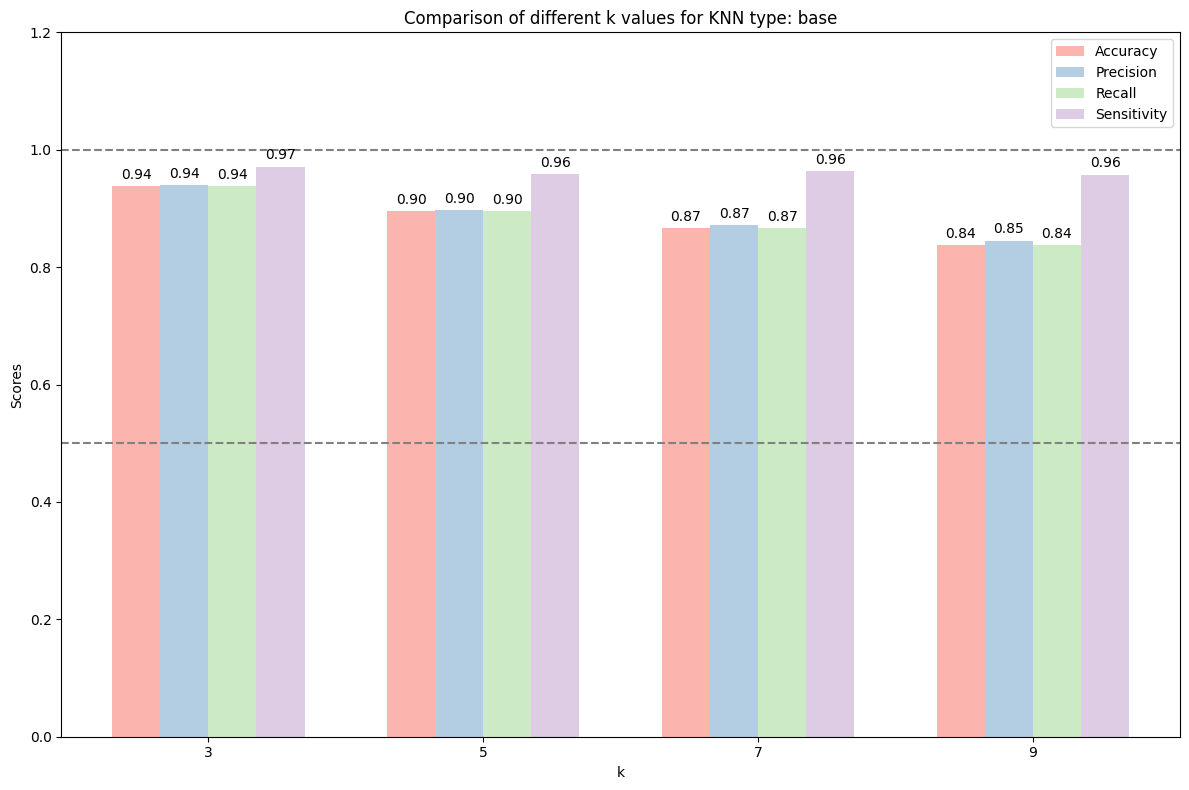

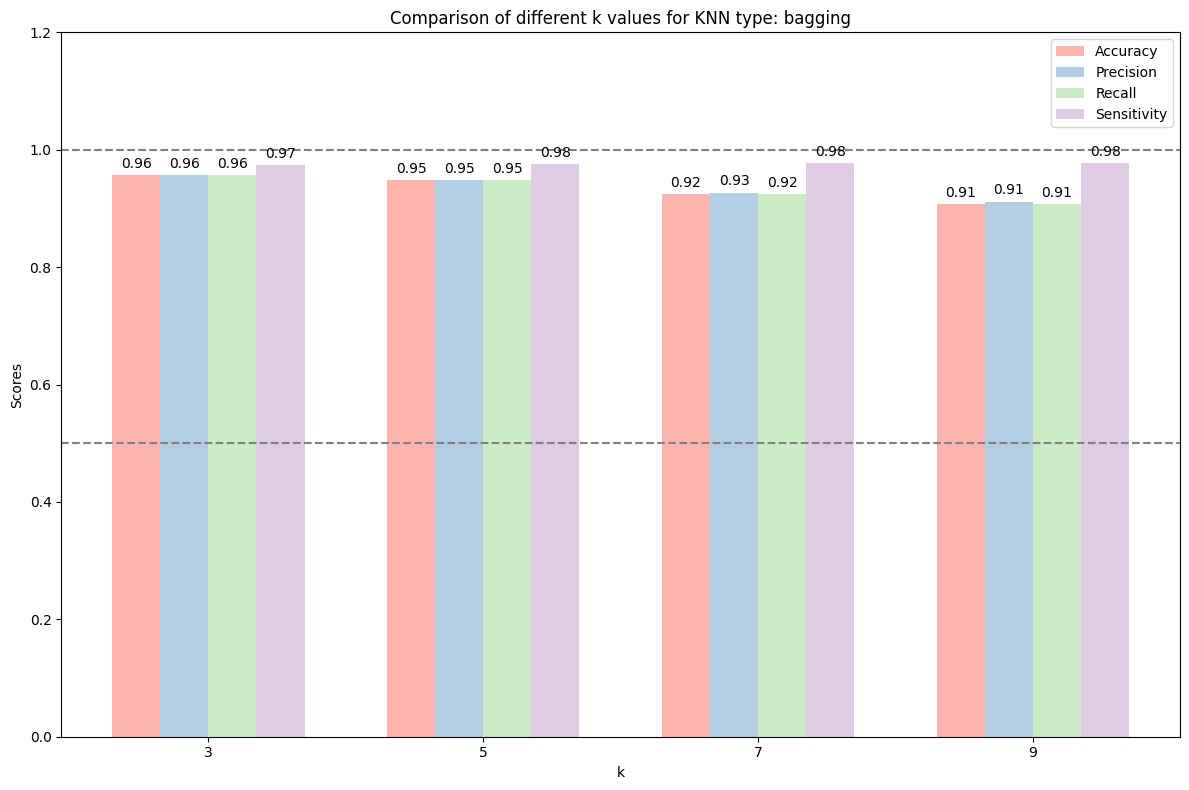

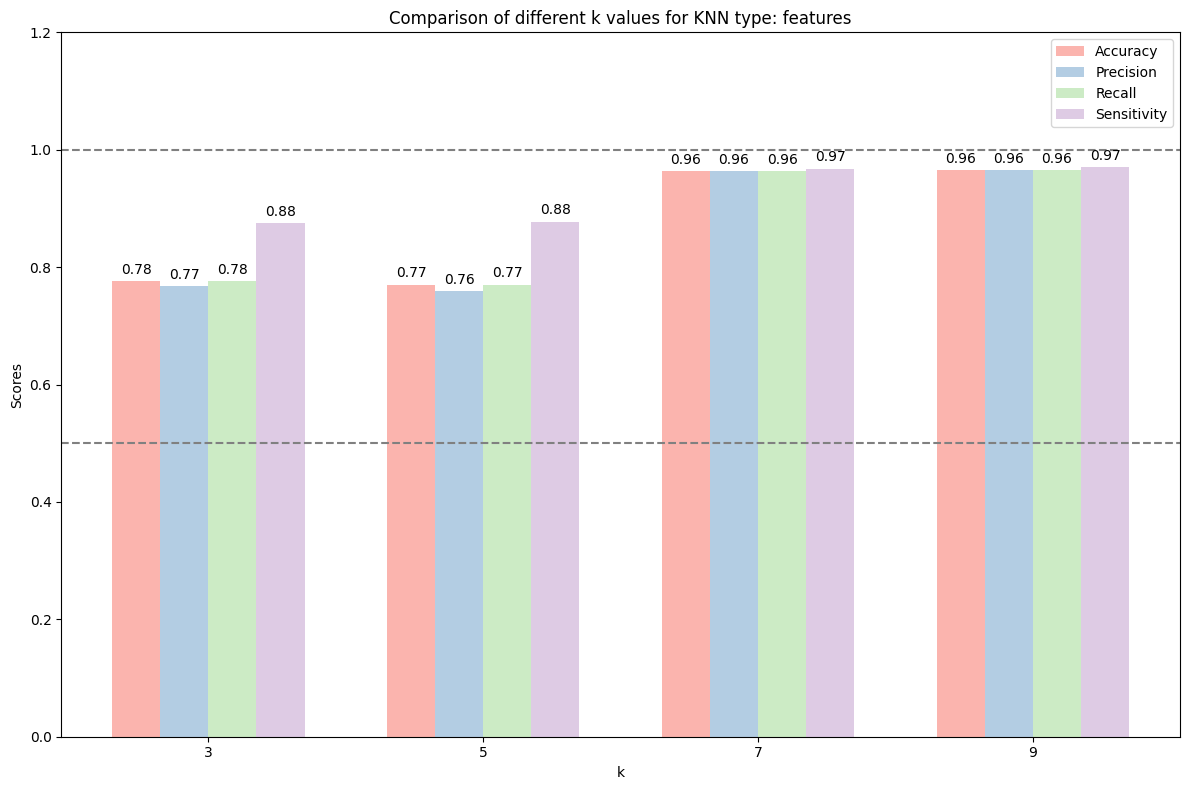

In [96]:
def plot_k_comparison(dataset_index, knn_type, kmax=10):
    csv_path = 'test_parameters.csv'
    df = pd.read_csv(csv_path)
    df = df[df['knn_type'] == knn_type]
    
    df = df[df['dataset_name'] == dataset_index]
    
    df = df[df['knn_type'] == knn_type]
    ks = list(range(3, kmax + 1, 2))
    results = {k: {'accuracy': [], 'precision': [], 'recall': [], 'sensitivity': []} for k in ks}
    
    for k in ks:
        df_k = df[df['k'] == k]
        
        if knn_type == 'bagging':
            best_indices = df_k.groupby(['test_split', 'k'])['accuracy'].idxmax()
            df_k = df_k.loc[best_indices]
        
        if not df_k.empty:
            results[k]['accuracy'] = df_k['accuracy'].mean()
            results[k]['precision'] = df_k['precision'].mean()
            results[k]['recall'] = df_k['recall'].mean()
            results[k]['sensitivity'] = df_k['sensitivity'].mean()

    
    accuracies = [results[k]['accuracy'] for k in ks]
    precisions = [results[k]['precision'] for k in ks]
    recalls = [results[k]['recall'] for k in ks]
    sensitivities = [results[k]['sensitivity'] for k in ks]

    x = np.arange(len(ks))
    width = 0.175

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.Pastel1.colors

    rects1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color=colors[0])
    rects2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color=colors[1])
    rects3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color=colors[2])
    rects4 = ax.bar(x + 1.5*width, sensitivities, width, label='Sensitivity', color=colors[3])

    ax.set_xlabel('k')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of different k values for KNN type: {}'.format(knn_type))
    ax.set_xticks(x)
    ax.set_xticklabels(ks)
    ax.set_ylim(0, 1.2)
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)
    add_labels(rects4)

   
    ax.axhline(0.5, color='gray', linestyle='--')
    ax.axhline(1, color='gray', linestyle='--')
    fig.tight_layout()
    plt.show()

plot_k_comparison(1, knn_type='base', kmax=10)
plot_k_comparison(1, knn_type='bagging', kmax=10)
plot_k_comparison(1, knn_type='features', kmax=10)

### Distance Comparison <a name="distance-comparison"></a>
[[go back to the topic]](#parameters)

Below, we can observe the distinctions among each method again, but for this one we conducted tests for each implemented distance metric.

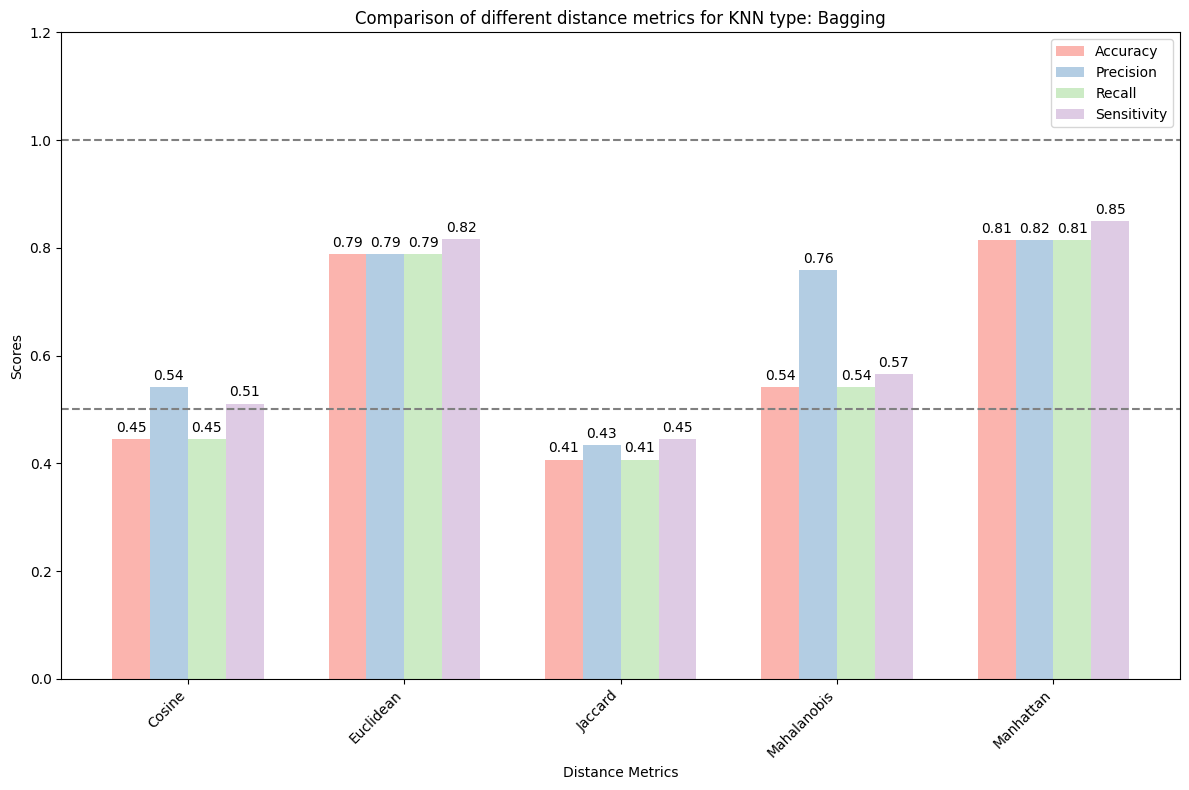

In [4]:
def plot_distance_comparison():
    distances = ['Cosine', 'Euclidean', 'Jaccard', 'Mahalanobis', 'Manhattan']
    results = {distance: {'accuracy': [], 'precision': [], 'recall': [], 'sensitivity': []} for distance in distances}

    for i in range(1, 11):
        csv_path = f'parameters_dataset_filtered_{i}.csv'
        df = pd.read_csv(csv_path)
        df = df[df['knn_type'] == 'bagging']

        for distance in distances:
            df_distance = df[df['distance'] == distance]

            if not df_distance.empty:
                best_indices = df_distance.groupby(['distance'])['accuracy'].idxmax()
                df_distance = df_distance.loc[best_indices]

            if not df_distance.empty:
                results[distance]['accuracy'].append(df_distance['accuracy'].mean())
                results[distance]['precision'].append(df_distance['precision'].mean())
                results[distance]['recall'].append(df_distance['recall'].mean())
                results[distance]['sensitivity'].append(df_distance['sensitivity'].mean())

    accuracies = [np.mean(results[distance]['accuracy']) for distance in distances]
    precisions = [np.mean(results[distance]['precision']) for distance in distances]
    recalls = [np.mean(results[distance]['recall']) for distance in distances]
    sensitivities = [np.mean(results[distance]['sensitivity']) for distance in distances]

    x = np.arange(len(distances))
    width = 0.175

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.Pastel1.colors

    rects1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color=colors[0])
    rects2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color=colors[1])
    rects3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color=colors[2])
    rects4 = ax.bar(x + 1.5*width, sensitivities, width, label='Sensitivity', color=colors[3])

    ax.set_xlabel('Distance Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of different distance metrics for KNN type: Bagging')
    ax.set_xticks(x)
    ax.set_xticklabels(distances, rotation=45, ha='right')
    ax.set_ylim(0, 1.2)
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)
    add_labels(rects4)

    ax.axhline(0.5, color='gray', linestyle='--')
    ax.axhline(1, color='gray', linestyle='--')
    fig.tight_layout()
    plt.show()

plot_distance_comparison()

## Test Statistics <a name="statistics"></a>
[[go back to the top]](#contents)

This section provides a suite of Python functions tailored for visual assessment and statistical evaluation of machine learning models, with a particular emphasis on different configurations of the K-Nearest Neighbors (K-NN) algorithm. Each function in this section is crafted to perform specific analyses and visualizations that contribute to a comprehensive understanding of model behavior and performance.

### Statistical Performance <a name="statistical-performance"></a>

The statistical performance is evaluated by calculating metrics including accuracy, precision, recall, error rate, sensitivity, and specificity

In [ ]:
def estatistics(dataset, algorithm, k, test_size):
    
    if algorithm == 'base':
        accuracy, y_test, predictions, X_test, clf, distance = train_base(dataset, k, test_size)
    elif algorithm == 'bagging':
        accuracy, y_test, predictions, X_test, clf, distance  = train_bagging_sameK(dataset, k, test_size)
    else:
        accuracy, y_test, predictions, X_test, clf, distance  = train_features(dataset, k, test_size)
    
    metrics = {}
    metrics['Precision'] = round(precision_score(y_test, predictions, average='weighted', zero_division=1),2)
    metrics['Recall'] = round(recall_score(y_test, predictions, average='weighted'),2)
    metrics['Error Rate'] = round(1 - accuracy,2)
    
    if is_numeric_dtype(y_test) and len(np.unique(y_test)) == 2:
        cm1 = confusion_matrix(y_test, predictions)
        metrics['Sensitivity'] = round(cm1[0,0] / (cm1[0,0] + cm1[0,1]) if cm1[0,0] + cm1[0,1] > 0 else 0,2)
        metrics['Specificity'] = round(cm1[1,1] / (cm1[1,0] + cm1[1,1]) if cm1[1,0] + cm1[1,1] > 0 else 0,2)

    if not is_numeric_dtype(y_test) or len(np.unique(y_test)) > 2:
        metrics['F1-score'] = f1_score(y_test, predictions, average='weighted')
    return metrics

# Example usage
estatistics(df1, 'bagging', 1, 0.3)


{'Precision': 0.97,
 'Recall': 0.97,
 'Error Rate': 0.03,
 'Sensitivity': 0.98,
 'Specificity': 0.96}

### Comparisons <a name="comparisons"></a>
[[go back to the topic]](#statistics)

In this section we provide the comparisons for each KNN method.


          K  Accuracy  Precision  Recall  Sensitivity            Distance
Method                                                                   
base      3      0.94       0.94    0.94         0.97           Eucledian
bagging   3      0.96       0.96    0.96         0.97           Manhattan
features  3      0.96       0.96    0.96         0.97  Eucledian Features


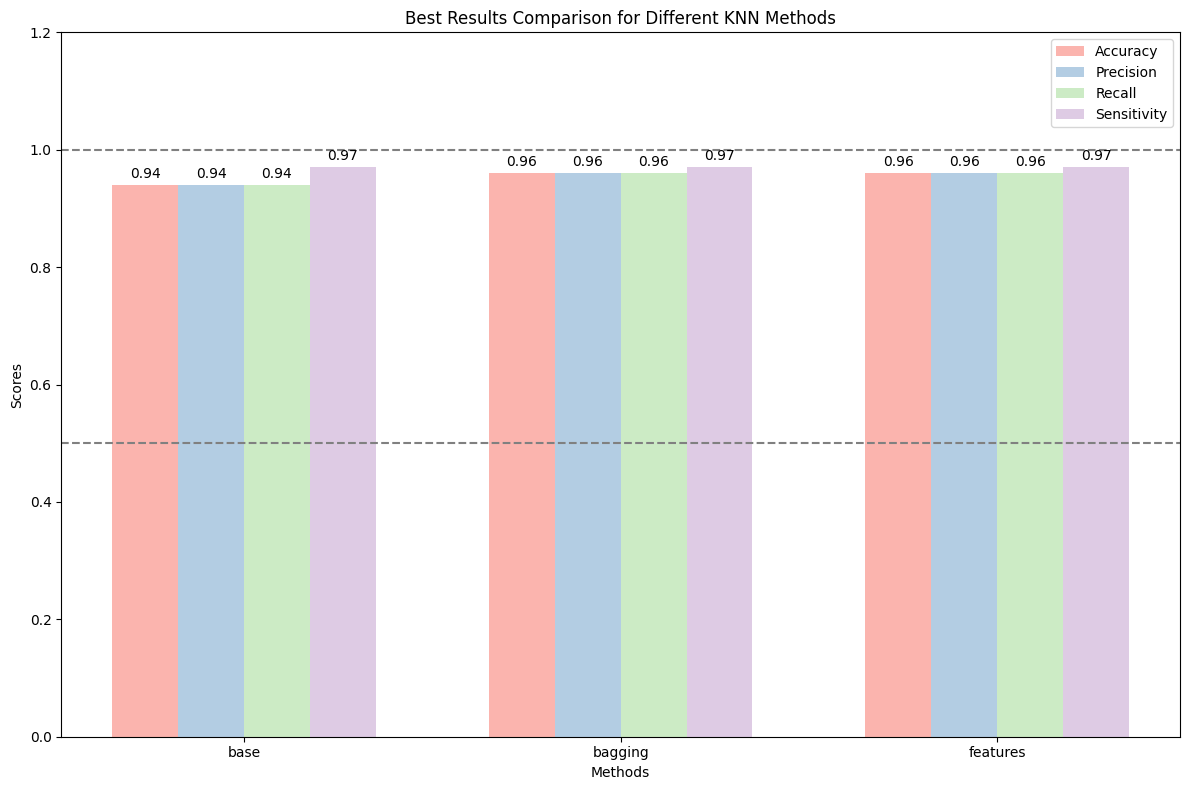

In [ ]:
def filter_csv_best():
    csv_path = 'parameters_dataset_filtered_1.csv'
    df = pd.read_csv(csv_path)
    return df

def find_best_result():
    df = filter_csv_best()
    
    methods = ['base', 'bagging', 'features']
    best_results = []

    for method in methods:
        method_df = df[df['knn_type'] == method]
        if not method_df.empty:
            max_accuracy_index = method_df['accuracy'].idxmax()
            best_row = method_df.loc[max_accuracy_index]

            best_k = best_row['k']
            best_accuracy = best_row['accuracy']
            best_precision = best_row['precision']
            best_recall = best_row['recall']
            best_sensitivity = best_row['sensitivity']
            best_distance = best_row['distance']

            best_results.append({
                'Method': method,
                'K': best_k,
                'Accuracy': best_accuracy,
                'Precision': best_precision,
                'Recall': best_recall,
                'Sensitivity': best_sensitivity,
                'Distance': best_distance
            })
        else:
            best_results.append({
                'Method': method,
                'K': None,
                'Accuracy': None,
                'Precision': None,
                'Recall': None,
                'Sensitivity': None,
                'Distance': None
            })

    results_df = pd.DataFrame(best_results)
    results_df.set_index('Method', inplace=True)

    return results_df

def plot_best_results(results_df):
    df = filter_csv_best()
    
    methods = results_df.index
    accuracies = []
    precisions = []
    recalls = []
    sensitivities = []

    for method in methods:
        best_params = results_df.loc[method]
        method_df = df[(df['knn_type'] == method) & 
                       (df['k'] == best_params['K']) & 
                       (df['distance'] == best_params['Distance'])]
        
        accuracies.append(method_df['accuracy'].mean())
        precisions.append(method_df['precision'].mean())
        recalls.append(method_df['recall'].mean())
        sensitivities.append(method_df['sensitivity'].mean())

    x = np.arange(len(methods))
    width = 0.175

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.Pastel1.colors

    rects1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color=colors[0])
    rects2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color=colors[1])
    rects3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color=colors[2])
    rects4 = ax.bar(x + 1.5*width, sensitivities, width, label='Sensitivity', color=colors[3])

    ax.set_xlabel('Methods')
    ax.set_ylabel('Scores')
    ax.set_title('Best Results Comparison for Different KNN Methods')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_ylim(0, 1.2)
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            if np.isnan(height):
                height = 0  # Handle NaN values
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)
    add_labels(rects4)

    ax.axhline(0.5, color='gray', linestyle='--')
    ax.axhline(1, color='gray', linestyle='--')
    fig.tight_layout()
    plt.show()

# Example of usage
results_table = find_best_result() 
print(results_table)
plot_best_results(results_table)

### Datasets <a name="datasets"></a>
[[go back to the top]](#contents)

Here, we initiate our process by reading the CSV files and conducting necessary pre-processing steps. 

In [68]:
df1 = pd.read_csv('csvs/breast.csv')
#print(df1.isnull().sum())
df1['Class'] = df1['Class'].replace({'benign': 0, 'malignant': 1})
df1['Bare_Nuclei'].replace('?', np.nan, inplace=True)
df1['Bare_Nuclei'] = pd.to_numeric(df1['Bare_Nuclei'], errors='coerce')
df1.dropna(subset=['Bare_Nuclei'], inplace=True)
#df1.head()

In [69]:
df2 = pd.read_csv('csvs/age_predictions_cleaned.csv')
#print(df2.isnull().sum())
df2['Class'] = df2['age_group']

In [70]:
df3 = pd.read_csv('csvs/diabetes.csv')
df3['Class'] = df3['class'].replace({'tested_negative': 0, 'tested_positive': 1})
df3.drop(columns=['class'], inplace=True)  # Remove a coluna 'class' original
#print(df3.isnull().sum())

In [71]:
df4=pd.read_csv('csvs/Raisin_Dataset.csv')
df4['Class'] = df4['Class'].replace({'Kecimen': 0, 'Besni': 1})
#print(df10.isnull().sum())
#df10.head()

In [72]:
df5=pd.read_csv('csvs/heart_disease2.csv')
df5['Class']=df5['target']
df5.drop(columns=['target'], inplace=True)
#print(df7.isnull().sum())

In [73]:
df6=pd.read_csv('csvs/lung_cancer_examples.csv')
df6.drop(columns=['Name'], inplace=True)
df6.drop(columns=['Surname'], inplace=True)
df6['Class']=df6['Result']
df6.drop(columns=['Result'], inplace=True)
#df6.head()
#print(df6.isnull().sum())

In [74]:
df7=pd.read_csv('csvs/Pumpkin_Seeds_Dataset.csv')
df7['Class']=df7[' Class        ']
#print(df7.isnull().sum())
df7.drop(columns=[' Class        '], inplace=True)
df7['Class'] = df7['Class'].replace({'CERCEVELIK': 0, 'URGUP_SIVRISI': 1})

In [75]:
df8=pd.read_csv('csvs/wine.csv')
df8['Class']=df8[' binaryClass            ']
df8.drop(columns=[' binaryClass            '], inplace=True)
df8['Class'] = df8['Class'].replace({'N': 0, 'P': 1})
#df8.head()
#print(df8.isnull().sum())

In [77]:
df9=pd.read_csv('csvs/citrus.csv')
df9['Class'] = df9['name']
df9['Class'] = df9['name'].replace({'orange': 0, 'grapefruit': 1})
df9.drop(columns='name',inplace=True)
#df9.head()
#print(df9.isnull().sum())

In [86]:
df10 = pd.read_csv('csvs/water_potability.csv')
df10['Class'] = df10['Potability']
df10 = df10.dropna(subset=['Potability'])
df10 = df10.drop(columns=['Potability'])
df10 = df10.dropna()

non_numeric_columns = df10.select_dtypes(exclude=['number']).columns
#print(df10.isnull().sum())
